## Lane Detection for Autonomous Driving car

In this project, a CNN is build to drive an autonomous car on a simulation in Unity. The data is collected in the training mode of Unity, the data contains the left, centre and right images of the road ahead taken from the driver's seat of the car for each time stamp. The data also contains acceleration, brake, steering angle and speed of the car.
To create the CNN, the centre image and the speed are considered as input and the acceleration, brake and steering angle are the output. In the testing mode of Unity, the inputs (centre image and speed) are fed to the CNN and the outputs (acceleration, brake and steering angle) are used to drive the car in autonomous mode. The final result is to drive the car in autonomous mode.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.image as img
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, concatenate
from keras import metrics
import cv2
from keras.models import Model, load_model
import sklearn.preprocessing as preprocessing

Using TensorFlow backend.


In [2]:
# function to read images and convert to yuv for better recognition
def read_images(image):
    image = img.imread(os.path.join(path, os.path.basename(image)))
    c_image = image[60:-25, :, :] # All background infomation is cropped out.
    yuv_im = cv2.cvtColor(c_image, cv2.COLOR_RGB2YUV) #convert to yuv
    return np.double(np.asarray(c_image))

In [3]:
headers = ['Center_Image', 'Left_Image', 'Right_Image', 'Steering_Angle', 'Throttle', 'Break', 'Speed']
# Log files from Unity with name of image and speed, acceleration, brake and steering angle.
data_df = pd.read_csv("D:\TUM\courses\Data Innovation LAb\extract images\driving_log.csv", names = headers)
images = data_df['Center_Image'].values
path = 'D:\TUM\courses\Data Innovation LAb\extract images/IMG/'

In [4]:
x = np.array([read_images(image) for image in images])

y = data_df[['Steering_Angle', 'Throttle', 'Break']].values
x_speed = data_df[['Speed']].values

# normalization of all the parameters. This normalization of parameters are also done to test the car with real time data
# acceleration and brake are already in range 0 to 1.

# normalization of Speed to range 0 to 1 
x_speed = preprocessing.normalize(x_speed, norm='max', axis=0)

# normalization of Steering angle to range -1 to 0 for left turn and 0 to 1 for right turn
y_min_sa = -1
y_max_sa = 1 
for i in range(y.shape[0]):
    y[i][0] = (y[i][0] - y_min_sa) / (y_max_sa - y_min_sa)

In [5]:
X_train, X_test, X_sp_train, X_sp_test, y_train, y_test = train_test_split(x, x_speed, y, test_size=0.1, random_state=0)

X_train = X_train.reshape(X_train.shape[0], 75, 320, 3)
X_test = X_test.reshape(X_test.shape[0], 75, 320, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [6]:
# To load saved model from previous training 
#model = load_model('autonomousDriving_model2_50E_5feb_sampleWeights.h5')

CNN is created using functional API model class.

In [7]:
# First layer defines the input shape. Input_shape= [height, width, color]
img_input_1 = Input(shape=(75, 320, 3), dtype='float32', name='main_input')
# Add layers to the model
# This convolutional layer applies 12 filters of size 3x3 to input and stacks them.
img_input_2 = Convolution2D(12, (3, 3), activation='relu', padding='same')(img_input_1)
# MaxPooling2D Layer applies max function on a sliding window of size 2x2
img_input_3 = MaxPooling2D(pool_size=(2, 2))(img_input_2)

img_input_4 = Convolution2D(24, (3, 3),  activation='relu')(img_input_3)

img_input_5 = MaxPooling2D(pool_size=(2, 2))(img_input_4)

img_input_6 = Convolution2D(32, (3, 3), activation='relu', padding='same')(img_input_5)

img_input_7 = MaxPooling2D(pool_size=(2, 2))(img_input_6)

img_input_8 = Convolution2D(64, (5, 5), activation='relu')(img_input_7)

img_input_9 = MaxPooling2D(pool_size=(2, 2))(img_input_8)

# Input image is Flattened by stacking everything to a vector.
img_input_10  = Flatten()(img_input_9) 

# Input speed is now considered
speed_input_1 = Input(shape=(1,), name='speed_input')

# Image and speed are concatenated.
merged_inputs_1 = concatenate([img_input_10, speed_input_1])

#Dropout sets randomly 25% of Input data to 0 to prevent overfitting.
merged_inputs_2 = Dropout(0.25)(merged_inputs_1)

# Fully connected layer.
merged_inputs_3 = Dense(64, activation='relu')(merged_inputs_2)

merged_inputs_4 = Dropout(0.5)(merged_inputs_3)

# 3 outputs. The three outputs are independent of each other.
output_1 = Dense(1)(merged_inputs_4)
output_2 = Dense(1)(merged_inputs_4)
output_3 = Dense(1)(merged_inputs_4)

# Keras functional API model
model = Model(inputs=[img_input_1, speed_input_1], outputs=[output_1, output_2, output_3])

In [8]:
op1 = output_1.name.split('/')[0]
op2 = output_2.name.split('/')[0]
op3 = output_3.name.split('/')[0]

# weight assigned to each output to improve learning.
sample_weights = np.array(y_train)
sample_weights[:,0]=2
sample_weights[:,1]=5
sample_weights[:,2]=1

sample_fit = { op1 : sample_weights[:,0],
          op2 : sample_weights[:,1],
          op3 : sample_weights[:,2]
         }

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [9]:
# Train the model
# Batch size defines how many images are used as a batch in each training step.
# Number epochs defines how often the whole set of data X and Y is processed for the training.
fitParams = model.fit([X_train, X_sp_train], [y_train[:,0],y_train[:,1],y_train[:,2]], validation_split=0.1,sample_weight = sample_fit, batch_size=32, epochs=50, verbose=1)

# Predict using model on test data
preds = model.predict([X_test, X_sp_test], batch_size=32, verbose=1)

Train on 330 samples, validate on 37 samples
Epoch 1/50
330/330 [==============================] - 14s - loss: 1.2518 - dense_2_loss: 0.2497 - dense_3_loss: 0.9673 - dense_4_loss: 0.0348 - dense_2_mean_absolute_error: 0.2771 - dense_3_mean_absolute_error: 0.3286 - dense_4_mean_absolute_error: 0.1381 - val_loss: 1.0594 - val_dense_2_loss: 0.1518 - val_dense_3_loss: 0.9068 - val_dense_4_loss: 7.4003e-04 - val_dense_2_mean_absolute_error: 0.2292 - val_dense_3_mean_absolute_error: 0.4138 - val_dense_4_mean_absolute_error: 0.0254
Epoch 2/50
330/330 [==============================] - 0s - loss: 1.1050 - dense_2_loss: 0.2173 - dense_3_loss: 0.8752 - dense_4_loss: 0.0125 - dense_2_mean_absolute_error: 0.2651 - dense_3_mean_absolute_error: 0.3402 - dense_4_mean_absolute_error: 0.0823 - val_loss: 0.8632 - val_dense_2_loss: 0.1471 - val_dense_3_loss: 0.7159 - val_dense_4_loss: 1.5656e-04 - val_dense_2_mean_absolute_error: 0.2155 - val_dense_3_mean_absolute_error: 0.3219 - val_dense_4_mean_absolut

330/330 [==============================] - 0s - loss: 0.2810 - dense_2_loss: 0.0818 - dense_3_loss: 0.1968 - dense_4_loss: 0.0025 - dense_2_mean_absolute_error: 0.1541 - dense_3_mean_absolute_error: 0.1381 - dense_4_mean_absolute_error: 0.0362 - val_loss: 0.2875 - val_dense_2_loss: 0.0799 - val_dense_3_loss: 0.2075 - val_dense_4_loss: 1.5744e-04 - val_dense_2_mean_absolute_error: 0.1456 - val_dense_3_mean_absolute_error: 0.1260 - val_dense_4_mean_absolute_error: 0.0101
Epoch 34/50
330/330 [==============================] - 0s - loss: 0.2407 - dense_2_loss: 0.0799 - dense_3_loss: 0.1581 - dense_4_loss: 0.0027 - dense_2_mean_absolute_error: 0.1605 - dense_3_mean_absolute_error: 0.1175 - dense_4_mean_absolute_error: 0.0397 - val_loss: 0.2773 - val_dense_2_loss: 0.0779 - val_dense_3_loss: 0.1992 - val_dense_4_loss: 2.2542e-04 - val_dense_2_mean_absolute_error: 0.1468 - val_dense_3_mean_absolute_error: 0.1298 - val_dense_4_mean_absolute_error: 0.0115
Epoch 35/50
330/330 [===================

In [10]:
model.save('model_trained.h5')

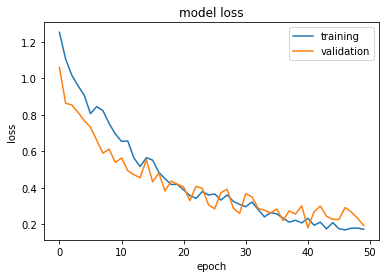

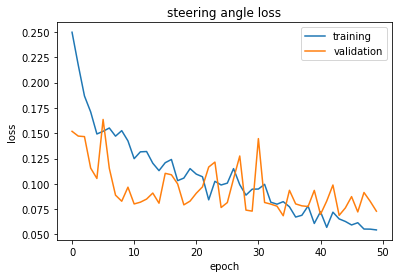

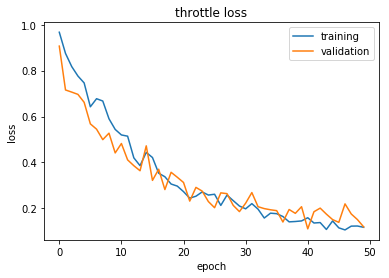

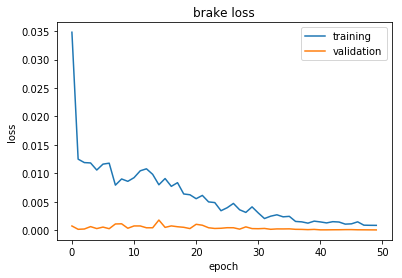

In [11]:
# summarize history for overall loss
plt.plot(fitParams.history['loss'])
plt.plot(fitParams.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


plt.plot(fitParams.history[str(op1)+'_loss'])
plt.plot(fitParams.history['val_'+str(op1)+'_loss'])
plt.title('steering angle loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


plt.plot(fitParams.history[str(op2)+'_loss'])
plt.plot(fitParams.history['val_'+str(op2)+'_loss'])
plt.title('throttle loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


plt.plot(fitParams.history[str(op3)+'_loss'])
plt.plot(fitParams.history['val_'+str(op3)+'_loss'])
plt.title('brake loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


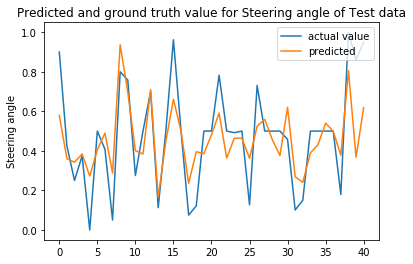

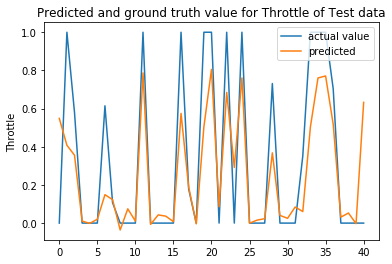

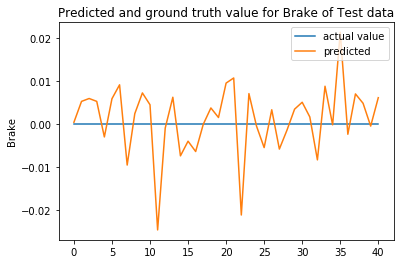

In [12]:
plt.plot(y_test[:,0])
plt.plot(preds[0])
plt.legend(['actual value','predicted'], loc='upper right')
plt.ylabel('Steering angle')
plt.title('Predicted and ground truth value for Steering angle of Test data')
plt.show()


plt.plot(y_test[:,1])
plt.plot(preds[1])
plt.legend(['actual value','predicted'], loc='upper right')
plt.ylabel('Throttle')
plt.title('Predicted and ground truth value for Throttle of Test data')
plt.show()

plt.plot(y_test[:,2])
plt.plot(preds[2])
plt.legend(['actual value','predicted'], loc='upper right')
plt.ylabel('Brake')
plt.title('Predicted and ground truth value for Brake of Test data')
plt.show()


Presently, the above code is run for 1200 images which is less and doesnt cover all scenarios. Brake in the data is never applied and not learnt properly, as seen in graphs.

The above code was run for 25000 images with different scenarios including car returning to lane if it goes outside lane. This model was successfully used in the Unity simulator to create an automous driving car.